In [1]:
# Geospatial data processing
import numpy as np
import geopandas as gpd
import networkx as nx
from shapely import Point


# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Network analysis
import osmnx as ox

# The star of the show: city2graph for transportation network analysis
import city2graph

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')
#plt.style.use('default')  # Clean default style instead of ggplot

print("All dependencies loaded successfully!")
print(f"city2graph version: {city2graph.__version__ if hasattr(city2graph, '__version__') else 'development'}")

All dependencies loaded successfully!
city2graph version: 0.1.6


In [2]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Liverpool city centre

bbox = [-42.865397,-5.231538,-42.662587,-4.955767] # Teresina city centre bounding box

city2graph.load_overture_data(
    area=bbox,
    #types=["segment", "building", "connector"],
    types=["segment", "building", "connector"],
    output_dir="./dados/overturemaps/",
    prefix="teresina_bbox_script_",
    save_to_file=True,
    return_data=False
)

print("Data loading configuration complete")
print("To download fresh data, uncomment the city2graph.load_overture_data() call above")

Data loading configuration complete
To download fresh data, uncomment the city2graph.load_overture_data() call above


In [9]:
# Load the downloaded GeoJSON files
buildings_gdf = gpd.read_file("./dados/overturemaps/teresina_bbox_script_building.geojson")
ubs_gdf = gpd.read_file("./dados/semplam/ubs_zu.geojson")
segments_gdf = gpd.read_file("./dados/overturemaps/teresina_bbox_script_segment.geojson")
connectors_gdf = gpd.read_file("./dados/overturemaps/teresina_bbox_script_connector.geojson")

# Convert to UTM 23 Sul Grade (EPSG:31983) for accurate distance calculations
buildings_gdf = buildings_gdf.to_crs(epsg=31983)
segments_gdf = segments_gdf.to_crs(epsg=31983)
connectors_gdf = connectors_gdf.to_crs(epsg=31983)

print("✅ Data loaded successfully!")
print(f"📊 Dataset summary:")
print(f"   • Buildings: {len(buildings_gdf):,}")
print(f"   • UBS: {len(ubs_gdf):,}")
print(f"   • Road segments: {len(segments_gdf):,}")
print(f"   • Connectors: {len(connectors_gdf):,}")
print(f"   • CRS: {ubs_gdf.crs}")
print(f"   • CRS: {buildings_gdf.crs}")

✅ Data loaded successfully!
📊 Dataset summary:
   • Buildings: 433,496
   • UBS: 75
   • Road segments: 54,077
   • Connectors: 39,091
   • CRS: EPSG:4674
   • CRS: EPSG:31983


In [3]:
segments_gdf.head(2)

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,level_rules,destinations,prohibited_transitions,rail_flags,road_surface,road_flags,speed_limits,width_rules,subclass,geometry
0,3fbedeb9-2fde-48fa-b73d-4ce98ca6d8a3,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",rail,standard_gauge,"{ ""primary"": ""Ferrovia Transnordestina"", ""comm...","[ { ""connector_id"": ""b16574d6-dad8-4c12-8dbf-b...",None,None,None,"[ { ""value"": 1, ""between"": [ 0.0, 0.0076383589...",None,None,"[ { ""values"": [ ""is_bridge"" ], ""between"": [ 0....",None,None,None,None,None,"LINESTRING (741318.351 9437513.182, 741314.222..."
1,effc0f97-d37e-42d0-9229-b1af5b811c78,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,path,None,"[ { ""connector_id"": ""58eb7281-f8e3-4887-8db6-7...",None,None,None,None,None,None,None,None,None,None,None,None,"LINESTRING (737321.302 9421468.061, 737187.935..."


In [4]:
buildings_gdf.head(2)

,id,version,sources,level,subtype,class,height,names,has_parts,is_underground,num_floors,facade_color,facade_material,roof_material,roof_shape,roof_orientation,roof_color,geometry
0,288de876-54b3-4fdd-b322-0b5ade4c2454,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",NaN,None,None,NaN,None,False,False,NaN,None,None,None,None,None,None,"POLYGON ((738647.984 9421342.366, 738643.725 9..."
1,449e9738-0057-40d4-96f7-d4626691912a,3,"[ { ""property"": """", ""dataset"": ""Microsoft ML B...",NaN,None,None,NaN,None,False,False,NaN,None,None,None,None,None,None,"POLYGON ((739680.557 9421496.24, 739680.151 94..."


In [5]:
connectors_gdf.head()

,id,version,sources,geometry
0,37cf3a2f-c798-4c97-b66d-e95b7be39d89,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (737120.948 9421346.489)
1,58eb7281-f8e3-4887-8db6-7f894da496d4,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (737321.302 9421468.061)
2,77448d18-7862-4d4b-bb1f-d15c86b50133,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (738494.288 9421391.665)
3,327217e8-1201-49ca-9aba-66253a3d245f,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (738700.06 9421332.752)
4,10c9bbfc-195f-488e-a046-c816f06b21f8,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",POINT (742875.108 9421337.183)


# 3. Street Network Processing

Before creating morphological graphs, we need to process the raw street data. This involves:

1. **Filtering**: Keep only road segments (exclude pedestrian paths, railways, etc.)
2. **Barrier Processing**: Handle bridges and tunnels to create accurate spatial barriers
3. **Network Cleanup**: Ensure proper connectivity for graph operations

The `barrier_geometry` column will contain the processed geometries that act as spatial barriers for tessellation.

In [ ]:
# >>> INÍCIO DO NOVO CÓDIGO DE FILTRAGEM <<<
print(f"Número de segmentos de via antes da 1ª filtragem: {len(segments_gdf)}")

# 1. PRIMEIRO FILTRO: Manter apenas subtype == 'road' (excluding pedestrian paths, railways, etc.)
segments_gdf_step1 = segments_gdf[segments_gdf['subtype'] == 'road'].copy()
print(f"Número de segmentos após filtrar por subtype='road': {len(segments_gdf_step1)}")


# 2. SEGUNDO FILTRO: Sobre o resultado anterior, filtrar pela classe da via
vias_para_manter = [
    'primary', 
    'secondary', 
    'tertiary', 
    'trunk', 
    'residential', 
    'unclassified'
]
# Filtra o GeoDataFrame do passo 1, mantendo apenas as classes desejadas
segments_gdf_filtrado1 = segments_gdf_step1[segments_gdf_step1['class'].isin(vias_para_manter)].copy()

print(f"Número de segmentos após filtrar por 'class' (resultado final): {len(segments_gdf_filtrado1)}")

Número de segmentos de via antes da 1ª filtragem: 54077
Número de segmentos após filtrar por subtype='road': 54044
Número de segmentos após filtrar por 'class' (resultado final): 49749


In [16]:
# Process segments to handle bridges/tunnels and create proper spatial barriers
segments_gdf = city2graph.process_overture_segments(
    segments_gdf=segments_gdf_filtrado1,
    get_barriers=True,
    connectors_gdf=connectors_gdf
)

print(f"✅ Processed {len(segments_gdf)} road segments")
print(f"📈 Barrier geometries created for tessellation")

barriers = segments_gdf["barrier_geometry"]

# Check the geometry types in the barrier_geometry column
geometry_types = segments_gdf["barrier_geometry"].geom_type.value_counts()
print(f"\n🔍 Barrier geometry types:")
for geom_type, count in geometry_types.items():
    print(f"   • {geom_type}: {count:,}")

✅ Processed 52710 road segments
📈 Barrier geometries created for tessellation

🔍 Barrier geometry types:
   • LineString: 52,633
   • MultiLineString: 71


<Axes: >

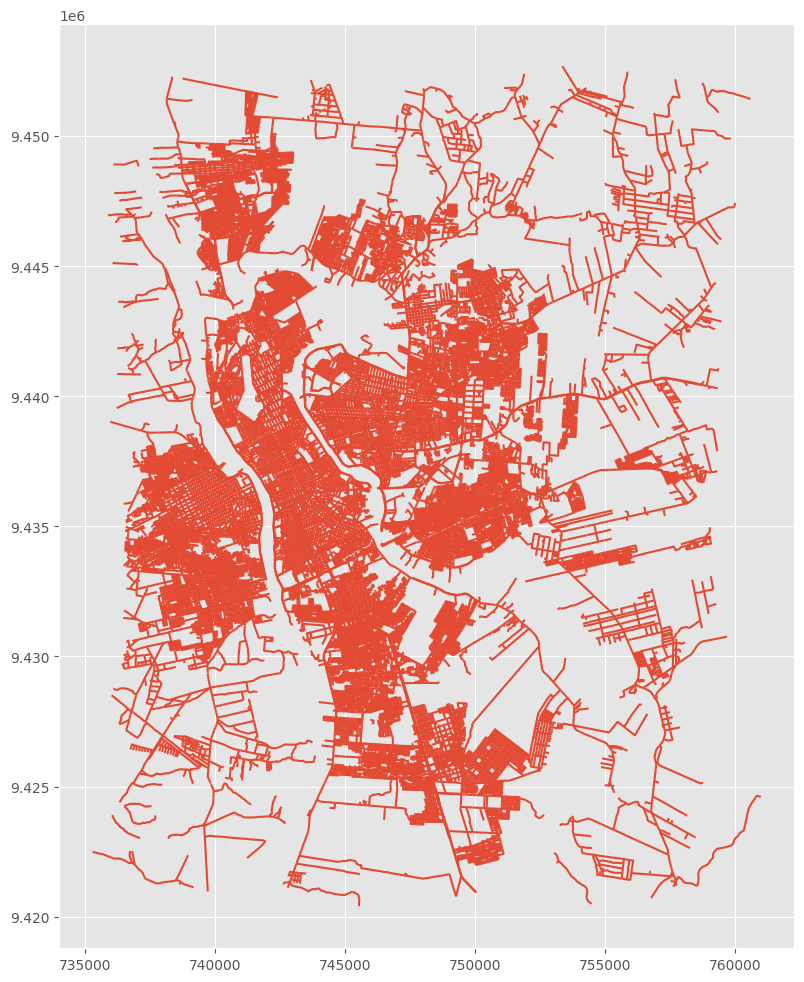

In [18]:
barriers.plot()

In [19]:
segments_gdf.head()

,id,version,sources,subtype,class,names,connectors,routes,subclass_rules,access_restrictions,...,road_surface,road_flags,speed_limits,width_rules,subclass,geometry,split_from,split_to,length,barrier_geometry
0,0787c5cd-327e-4988-9a42-46b1b177d068,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,unclassified,None,"[ { ""connector_id"": ""327217e8-1201-49ca-9aba-6...",None,None,None,...,"[ { ""value"": ""unpaved"", ""between"": null } ]",None,None,None,None,"LINESTRING (738700.06 9421332.752, 738692.884 ...",NaN,NaN,122.211950,"LINESTRING (738700.06 9421332.752, 738692.884 ..."
1,261dad10-bd6f-4e8b-bf61-dc895290aa43,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,unclassified,None,"[ { ""connector_id"": ""77448d18-7862-4d4b-bb1f-d...",None,None,None,...,"[ { ""value"": ""unpaved"", ""between"": null } ]",None,None,None,None,"LINESTRING (738494.288 9421391.665, 738537.555...",NaN,NaN,219.897743,"LINESTRING (738494.288 9421391.665, 738537.555..."
2,3f7eb654-4904-4965-b0d5-31b0882ec3a5,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,unclassified,None,"[ { ""connector_id"": ""327217e8-1201-49ca-9aba-6...",None,None,None,...,"[ { ""value"": ""unpaved"", ""between"": null } ]",None,None,None,None,"LINESTRING (738700.06 9421332.752, 738719.486 ...",NaN,NaN,524.031966,"LINESTRING (738700.06 9421332.752, 738719.486 ..."
3,895368f6-d697-42f6-a5ed-f66f0290b41f,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,primary,None,"[ { ""connector_id"": ""81324a00-4f0f-4821-8918-c...",None,None,None,...,"[ { ""value"": ""paved"", ""between"": null } ]",None,None,None,None,"LINESTRING (742793.053 9421113.85, 742817.028 ...",NaN,NaN,237.932697,"LINESTRING (742793.053 9421113.85, 742817.028 ..."
4,0fb7640d-36f6-4f9a-bf94-bf2f77024835,1,"[ { ""property"": """", ""dataset"": ""OpenStreetMap""...",road,unclassified,None,"[ { ""connector_id"": ""b3765137-c130-466f-bb5c-e...",None,None,None,...,"[ { ""value"": ""unpaved"", ""between"": null } ]",None,None,None,None,"LINESTRING (742629.125 9421240.662, 742633.244...",NaN,NaN,291.395627,"LINESTRING (742629.125 9421240.662, 742633.244..."


In [15]:
# Extra controle
# ===================================================================
# ===================================================================

# Definir o nome do arquivo de saída
output_filename = 'dados/overturemaps/resultado/segments_road_filtrado.geojson'

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
segments_gdf_filtrado1.to_file(
    output_filename, 
    driver='GeoJSON', 
    encoding='utf-8',
    crs='31983',
    engine='fiona'
)

print(f"Arquivo GeoJSON salvo com sucesso em: {output_filename}")

Arquivo GeoJSON salvo com sucesso em: dados/overturemaps/resultado/segments_road_filtrado.geojson


# 4. Creating Morphological Graphs

Now we’ll create the morphological graph - the core contribution of city2graph. This process:

![image.png](https://city2graph.net/_images/morph_net_process.png)

## The Process:

1. **Tessellation Creation**: Divide space into private areas using street segments as barriers
2. **Network Extraction**: Identify three types of spatial relationships:
    - Private-to-private (red): Adjacency between neighboring private spaces
    - Public-to-public (blue): Connectivity along street networks
    - Private-to-public (purple): Interface between private spaces and streets

## Why Morphological Graphs?

Unlike traditional approaches that analyze street networks and buildings separately, morphological graphs provide a **unified representation** of urban space that:

- Captures the complete topology of public and private spaces
- Enables holistic urban analysis combining street accessibility and land use
- Provides a foundation for spatially-explicit graph machine learning
- Supports integration of diverse urban attributes (POIs, demographics, functions)

In [20]:
# Define center point for the analysis area (Centro da cidade de Teresina)
center_point = gpd.GeoSeries([Point(-5.08305465, -42.77597849)], crs='EPSG:4326').to_crs(epsg=31983)

# Garante que os índices sejam numéricos, simples e sequenciais
#buildings_gdf = buildings_gdf.reset_index(drop=True)
#segments_gdf = segments_gdf.reset_index(drop=True)

# Create the morphological graph
print("🏗️  Creating morphological graph...")
morpho_nodes, morpho_edges = city2graph.morphological_graph(
    buildings_gdf=buildings_gdf,
    segments_gdf=segments_gdf,
    center_point=center_point,
    distance=500,                    # Analysis radius in meters
    clipping_buffer=300,            # Buffer for edge effects
    primary_barrier_col='barrier_geometry',
    contiguity="queen",             # Adjacency rule for tessellation
    keep_buildings=True,            # Preserve building geometries
)

print("✅ Morphological graph created successfully!")
print(f"📊 Network summary:")
print(f"   • Node types: {list(morpho_nodes.keys())}")
print(f"   • Edge types: {list(morpho_edges.keys())}")
print(f"   • Private spaces: {len(morpho_nodes['private']):,}")
print(f"   • Public spaces: {len(morpho_nodes['public']):,}")

for edge_type, edge_gdf in morpho_edges.items():
    print(f"   • {edge_type}: {len(edge_gdf):,} connections")

Removed 2 invalid geometries


🏗️  Creating morphological graph...


TypeError: You have to supply one of 'by' and 'level'

In [ ]:
morpho_nodes["private"].head()


In [ ]:
morpho_nodes["public"].head()


In [ ]:
morpho_edges[('public', 'connected_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'faced_to', 'public')].head()


In [ ]:
morpho_edges[('private', 'touched_to', 'private')].head()


In [ ]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right',
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()